## Population vector analyses
This tutorial introduces you to some of the basics behind population vector analyses. It will cover how to bin spike data, perform dimensionality reduction on it, and categorize states of population activity.

In [1]:
import sys
import pynapple as nap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from numpy.linalg import svd
from sklearn.cluster import KMeans
sys.path.append('../code/') # for relative import in jupyter notebook
from fileio.loadphy import as_pynapple

### Load spiking data
First we load the spike times as a time series group object.

In [2]:
phy_dir = '../test_data/phy/'
spks = as_pynapple(phy_dir)
num_units = len(spks)
print('There are {} units in this recording'.format(num_units))

There are 15 units in this recording


### Bin spiking activity
The time series group object in pynapple has a built in binning function called count. It finds the number of spikes in each bin for each unit in the group.

In [3]:
bin_size = 0.1 # in seconds, so 100ms
spks_bin = spks.count(0.1)

Since single units can have very different firing rates, and we are interested in the *pattern* of activity across the population, we need to normalize their times to a common scale. Z-scoring, subtracting the mean and dividing by the standard deviation, is a common way to do this.

In [4]:
def ztrans(data):
    zdata = (data-np.mean(data,axis=0))/np.std(data,axis=0)
    zdata[np.isnan(zdata)] = 0
    return zdata

spks_bin_z = ztrans(spks_bin)

Now we can plot the entire session and see how the activity varies over time.

<AxesSubplot: xlabel='Time (s)', ylabel='Unit ID'>

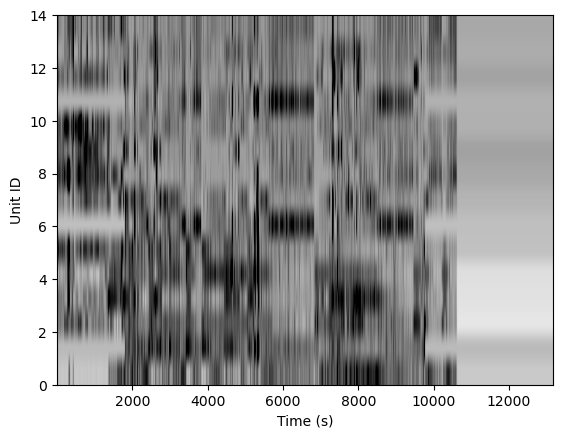

In [5]:
def popplot(data, ax=None, tlim=None):
    if ax is None:
        fig, ax = plt.subplots()

    bin_times = data.index.values
    bin_ids = data.columns.values
    bin_np = data.values.T
    ax.imshow(bin_np,vmin=-1,vmax=1,cmap='binary',
              extent=(bin_times[0], bin_times[-1],bin_ids[0], bin_ids[-1]))
    if tlim is not None:
        ax.set_xlim(tlim)
    ax.set_aspect('auto')
    ax.set_xlabel(data.index.name)
    ax.set_ylabel('Unit ID')
    return ax

popplot(spks_bin_z)

Notice that the spiking activity ceases around 10,000 seconds into the recording, probably due to a disconnection. Let's regenerate our binned spiking array restricted to the period when spiking was present.

Last spike was fired at 10604.96 seconds


<AxesSubplot: xlabel='Time (s)', ylabel='Unit ID'>

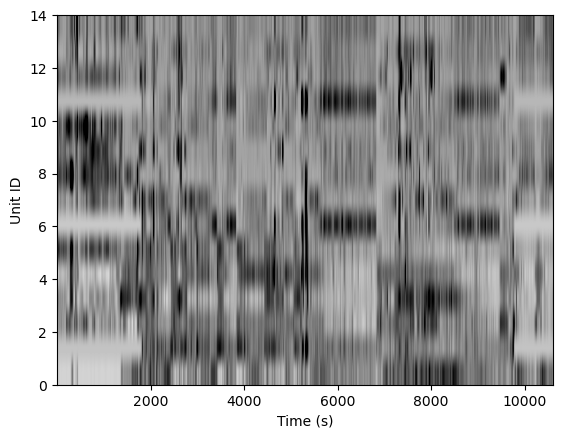

In [6]:
# get the time of the last spike across all units
last_spk = np.max([x.index.values[-1] for x in spks.values()])
print("Last spike was fired at {} seconds".format(round(last_spk,2)))

# create pynapple interval set for restricting binning
spk_seg = nap.IntervalSet(0,last_spk)
spks_bin = spks.restrict(spk_seg).count(bin_size)
spks_bin_z = ztrans(spks_bin)

# now let's plot to make sure we removed the spike-free portion
popplot(spks_bin_z)

The activity appears nonstationary, meaning that the statistical properties of the spiking changes with time. This is evident by periods where subsets of neurons are activated and then go silent, replaced by a different subset. We can look within some of these periods to see how the activity looks on a finer time scale.

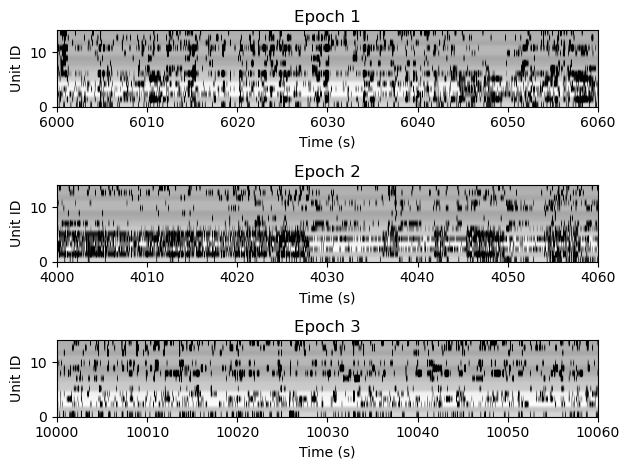

In [7]:
fig, ax = plt.subplots(3)
popplot(spks_bin_z,ax=ax[0],tlim=[6000, 6060])
ax[0].set_title('Epoch 1')
popplot(spks_bin_z,ax=ax[1],tlim=[4000, 4060])
ax[1].set_title('Epoch 2')
popplot(spks_bin_z,ax=ax[2],tlim=[10000, 10060])
ax[2].set_title('Epoch 3')
fig.tight_layout()

It appears that the covariation of activities between neurons varies with the timescale investigated. On the previous slow time scale (minutes) we saw elevated activities for certain groups of units, but now at faster time scales (seconds) those same units do not appear to coordinate their spiking. Let's try using some dimensionality reduction techniques to capture these differences.

In [8]:
# slow timescale population activity
slow_time = 60 # 1 minute
spks_bin_sz = ztrans(spks.count(bin_size=slow_time, ep=spk_seg))

# fast timescale population activity
fast_time = 0.1 # 100 ms
spks_bin_fz = ztrans(spks.count(bin_size=0.1, ep=spk_seg))

### Traditional principal component analysis of population activity
A common technique to reduce the dimensionality of population vectors is principal component analysis (PCA). It is a form of matrix decomposition that identifies components (or coefficients) that capture the covariance of multivariate data, and then for each observation assigns scores the contribution of each component. PCA is often calculated using another matrix decomposition algorithm, singular value decomposition (SVD). In SVD, an NxM matrix is decomposed into three new matrices:
- **U**: an NxN matrix of the 'column-space' components
- **s**: an NxM diagonal matrix of the singular values (note: numpy returns this as a vector of singular values)
- **V\***: an MxM matrix of the 'row-space' components

Multiplying these three matrices together reconstructs the original matrix. The components and singular values returned by SVD are ordered by how much variance in the original matrix they explain. We can choose to include only the early components to create an approximate reconstruction of the data. The number of components we use for the reconstruction is referred to as the order.

PCA can be derived from SVD. The PCA coefficients are the **V** matrix. PCA scores are the **U** matrix multiplied by the **s** matrix. Similar to SVD, in PCA if we increase the number of components (coefficients) used to we get a more accurate reconstruction of the data. The number of components used for PCA is also referred to as the order.


In [9]:
# make a PCA function using numpy's SVD function
def pca(data):
    u,s,v = svd(data-np.mean(data,axis=0))
    coeff = v
    score = u[:,0:data.shape[1]]*s
    return coeff, score

# function to reconstruct population activity from PCs
def rec_func(pc_c,pc_s,order=1):
    return pc_s[:,0:order]@pc_c[0:order,:]

# function to calculate explained variance of reconstruction
def exv_func(orig, recon):
    return (np.var(recon)/np.var(orig))*100


Let's examine how well PCA performs for reconstructing the population activity. We will start with the slow time scale binned activity, and vary the number of components used in the reconstruction.

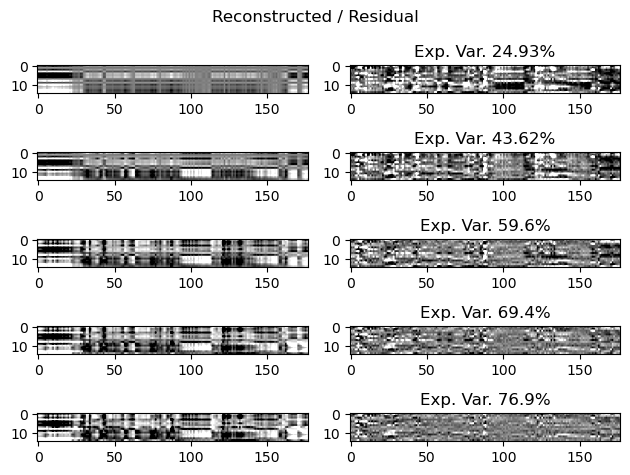

In [10]:
coeff_s, score_s = pca(spks_bin_sz.values)

fig, ax = plt.subplots(5,2)
for i in range(1,6):
    spks_bin_recon = rec_func(coeff_s,score_s,i)
    spks_bin_orig = spks_bin_sz.values
    ax[i-1,0].imshow(spks_bin_recon.T, vmin=-1, vmax=1,cmap='binary')
    ax[i-1,1].imshow((spks_bin_recon-spks_bin_orig).T, vmin=-1, vmax=1,cmap='binary')
    ax[i-1,1].set_title("Exp. Var. {}%".format(round(exv_func(spks_bin_orig,spks_bin_recon),2)))
    ax[i-1,0].set_aspect('auto')
    ax[i-1,1].set_aspect('auto')
fig.suptitle('Reconstructed / Residual')
fig.tight_layout()
plt.show()

Looks like just 5 components are sufficient to explain over 75% of the variance in population activity on a slow time scale.

Now let's do the same for the fast timescale.

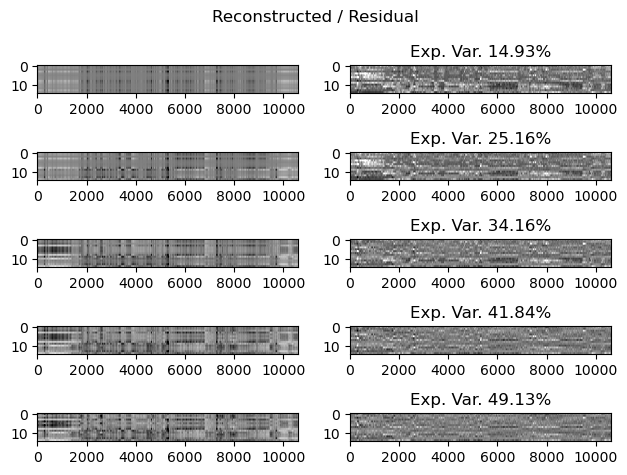

In [11]:
coeff_f, score_f = pca(spks_bin_fz.values[::10,:]) # note we skip time steps to speed up calculation

fig, ax = plt.subplots(5,2)
for i in range(1,6):
    spks_bin_recon = rec_func(coeff_f,score_f,i)
    spks_bin_orig = spks_bin_fz.values[::10,:]
    ax[i-1,0].imshow(spks_bin_recon.T, vmin=-1, vmax=1,cmap='binary')
    ax[i-1,1].imshow((spks_bin_recon-spks_bin_orig).T, vmin=-1, vmax=1,cmap='binary')
    ax[i-1,1].set_title("Exp. Var. {}%".format(round(exv_func(spks_bin_orig,spks_bin_recon),2)))
    ax[i-1,0].set_aspect('auto')
    ax[i-1,1].set_aspect('auto')
fig.suptitle('Reconstructed / Residual')
fig.tight_layout()
plt.show()

Compared with the slow, the 5th order reconstruction of the fast time scale population activity does not perform as well. Looking back on the fast time scale activity we visualized above, it should be obvious that there is greater heterogeneity in the population vectors from one time step to the next. Thus, one components would be required to capture its variance.

Besides differeing in their reconstruction quality, it may also be the case that the components identifed by PCA are different between the fast and slow time scales. We can visualize these components directly as image plots.

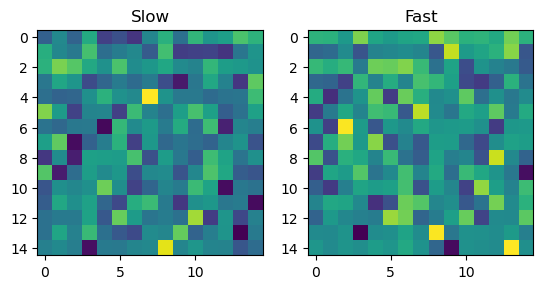

In [12]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(coeff_s)
ax[0].set_title('Slow')
ax[1].imshow(coeff_f)
ax[1].set_title('Fast')
plt.show()

Each row is a different component. They are ordered by how much variance they explain, with the top row explaining the most. The matrices do not look identical, but it would be best to compare each pair of components between them. One way to do this is by calculating the R^2 between each pair of components.

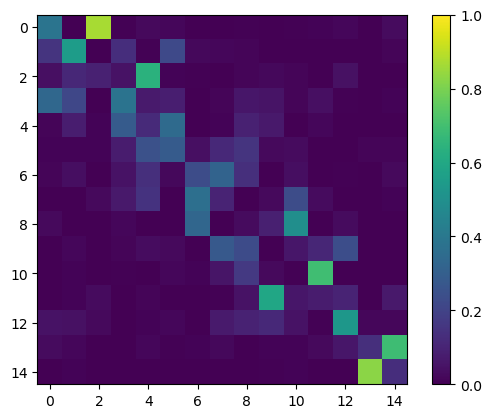

In [13]:
def corr_rows(mat1,mat2):
    matcorr = np.zeros((num_units,num_units))
    for x,y in product(range(num_units),range(num_units)):
        matcorr[x,y] = np.corrcoef(mat1[x,:],mat2[y,:])[0,1]**2
    return matcorr

pc_corr = corr_rows(coeff_s,coeff_f)

fig,ax = plt.subplots()
im_obj = ax.imshow(pc_corr, vmin=0, vmax=1)
plt.colorbar(im_obj)
plt.show()

There is a notable diagonal band for the correlation matrix, indicating that components of the same order are more likely to be similar to each other. However, the correlation between components is not perfect. Only the first and third components are highly similar, while most of the others have correlations below 0.5. This indicates that population dynamics are different between the slow and fast time scales.

### Clustering population vectors
Since PCA can reduce the dimensionality of slow time scale population activity, we could try clustering that activity based on its scores. Here we will use the k-means algorithm to cluster population activity. K-means requires us to preselect the number of clusters to use, so we will go with 8, the default.

Once our population activity is clustered, we will color the binned population activity plot to visualize the quality of the clustering.

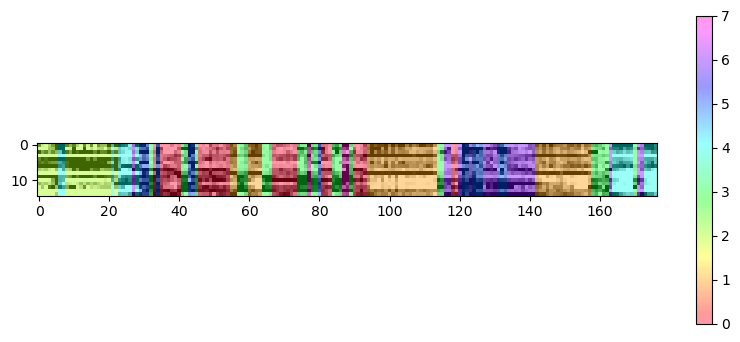

In [14]:
num_grps = 8
pop_grps = KMeans(num_grps).fit_predict(spks_bin_sz)

# color segments by group
fig,ax = plt.subplots()
ax.imshow(spks_bin_sz.values.T,cmap='binary',vmin=-1,vmax=1)
imh=ax.imshow(np.tile(pop_grps,(num_units,1)),alpha=0.4,cmap='gist_rainbow')
plt.colorbar(imh)
fig.set_size_inches(10,4)
plt.show()

The clustering seems to have worked well. Epochs with similar patterns of activated neurons have the same color. For instance, note the consistency of the population activity colored in red (cluster 0) and light green (cluster 3). However some clusters are a bit more heterogenous, such as those in orange (cluster 1).

Now that we have identified epochs of consisent population acivity on a slow time scale, we may be wondering how similar or dissimilar their activities are on a faster time scale. To capture this, we can analyze the covariance of population activity on the fast time scale within each epoch.

/var/folders/qz/bv9xctkn7n7c6jl3pc_7dl9h0000gn/T/ipykernel_66201/2274318261.py:2: RuntimeWarning: invalid value encountered in divide
  zdata = (data-np.mean(data,axis=0))/np.std(data,axis=0)
/var/folders/qz/bv9xctkn7n7c6jl3pc_7dl9h0000gn/T/ipykernel_66201/2274318261.py:2: RuntimeWarning: invalid value encountered in divide
  zdata = (data-np.mean(data,axis=0))/np.std(data,axis=0)


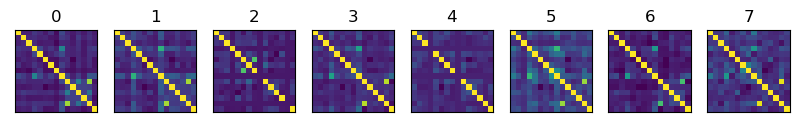

In [15]:
# calculate covariation in spiking between single units on a fast time within each slow time scale group
excl_edge = 10 # time to exclude from sample windows to avoid state transitions
coeff_grps = np.zeros((num_units,num_units,num_grps))
for i in range(num_grps):
    grp_inds = np.nonzero(pop_grps==i)[0]    
    start_times = (grp_inds*slow_time)+excl_edge
    end_times = ((grp_inds+1)*(slow_time)-excl_edge)
    curr_grp = nap.IntervalSet(start_times,end_times)
    curr_spks_bin = spks.restrict(curr_grp).count(fast_time)
    coeff_grps[:,:,i] = np.cov(ztrans(curr_spks_bin.values).T)

# plot covariance matrices
fig,ax = plt.subplots(1,num_grps)
for i in range(num_grps):
    ax[i].imshow(coeff_grps[:,:,i])
    ax[i].set_title(str(i))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.set_size_inches(10,3)
plt.show()

We can see some similarities and differences between these. This suggests that some faster correlations are preserved across different population states, which may reflect low-level circuits that are relatively immutable. However, overall differences in the fast correlations between neurons (e.g. compare 2 with 3) are also possible despite the fixed circuitry, perhaps reflecting radical changes in extrinsic inputs.